# <font style = "color:rgb(50,120,229)">Project: Visual Makeup</font>

# <font style = "color:rgb(50,120,229)">lips, eyes</font>

## <font style = "color:rgb(50,120,229)">The Core Idea</font>

To execute this project i am based on a couple of notebooks that we have already seen on the week 2 and 3 of the present course. The first step of the process leads to obtain the parts of the face that are goint to be used as makeup.

To apply a makeup on a face, i will use lips, eyelash from source image and apply it on the corresponding boundaries portions of face on destination image. In order to do this, i will need points marked on boundary areas.

As a source images i used images on png format, this due to PNG contains transparency mask. In that way i could use this mask for efficiently blending the lips and eyelash on the target face (my face).

i will use the points and affine warp it on the target image using delaunay triangulation. Just like face swap we will also use alpha blending to make blending look smooth. The difference here is that we will use transparency mask of beard and not the mask provided by the convex hull as in the case of faceswap.

In [18]:
import cv2,sys,dlib,time,math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../resource/lib/public')
import faceBlendCommon as fbc

In [11]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [12]:
# it is set the data path
directory_input = "../"
directory_output = "../"
modelPath = "../resource/lib/publicdata/models/shape_predictor_68_face_landmarks.dat" # Landmark model location

To execute this proyect i used as a reference the notebook where you taught us to put beard on others face.
The next image summarizes the source images in that case.

<img src="https://www.learnopencv.com/wp-content/uploads/2019/10/ted-beardify-annotation.jpg" width = 1000 />

In [97]:
# it is created a function to put makeup on lips, this function call the function "fn_apply_makeup" defined 1 cell below
def fn_Main_makeup_lips(modelPath,directory_input,directory_output):
    # Points corresponding to Dlib which have been marked on the lips original image
    selectedIndex = [48,50,52,54,56,58,60,62,64,66]

    # Load face detection and pose estimation models.
    modelPath = modelPath
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(modelPath)

    # Load the transparent png image with the alpha mask. This is done using the cv2.IMREAD_UNCHANGED flag.
    # I used the first three channels for the lips and the fourth channel as the mask for the lips.

    # Load the lips image with alpha mask 
    overlayFile = "./imageoriginal_0.png"
    imgWithMask = cv2.imread(overlayFile,cv2.IMREAD_UNCHANGED)
    
    # split the 4 channels
    b,g,r,a = cv2.split(imgWithMask)

    # Take the first 3 channels and create the bgr image to be warped
    lips = cv2.merge((b,g,r))
    lips = np.float32(lips)/255

    # Take the 4th channel and create the alpha mask used for blending
    lipsAlphaMask = cv2.merge((a,a,a))
    lipsAlphaMask = np.float32(lipsAlphaMask)
    plt.figure(figsize=[15,10])
    plt.subplot(121);plt.imshow(lips[...,::-1])
    plt.subplot(122);plt.imshow(np.uint8(lipsAlphaMask[...,::-1]))
    
    # Find delaunay triangles using these points to perform warping later.
    # coordinates in the original image corresponding to dlip landmarks, structure x,y, image of lips
    featurePoints1 = [[194,293],[223,272],[246,273],[277,289],[249,314],[218,312],[215,295],[237,291],[255,293],[237,298]]

    # Find delanauy traingulation for convex hull points
    sizeImg1 = lips.shape    
    rect = (0, 0, sizeImg1[1], sizeImg1[0])
    dt = fbc.calculateDelaunayTriangles(rect, featurePoints1)

    if len(dt) == 0:
        print("No delaunay triangle found")

    imageFile = "./foto_carnet_png.png"
    
    # it is called the function that applies the makeup
    out2,targetImage2 = fn_apply_makeup(imageFile,selectedIndex,featurePoints1,detector,predictor,rect,dt,sizeImg1,lipsAlphaMask,lips)
    plt.figure(figsize=[15,10])
    plt.subplot(121);plt.imshow(targetImage2[...,::-1]);plt.title("Original Image")
    plt.subplot(122);plt.imshow(out2[...,::-1]);plt.title("Image with lips")
    cv2.imwrite("./image_with_lips.png", np.uint8(255*out2))
    return

In [105]:
# it is created a function to execute whatever makeup on images, it is called on the corresponding main
def fn_apply_makeup(imageFile,selectedIndex,featurePoints1,detector,predictor,rect,dt,sizeImg1,lipsAlphaMask,lips):
    targetImage = cv2.imread(imageFile,cv2.IMREAD_UNCHANGED)
    height, width = targetImage.shape[:2]
    RESIZE_HEIGHT,RESIZE_WIDTH = lipsAlphaMask.shape[:2]
    IMAGE_RESIZE = np.float32(height)/RESIZE_HEIGHT
    targetImage = cv2.resize(targetImage,None,
                     fx=1.0/IMAGE_RESIZE,
                     fy=1.0/IMAGE_RESIZE,
                     interpolation = cv2.INTER_LINEAR)

    #Specify the resize options for working image and image used for Dlib face detector.
    FACE_DOWNSAMPLE_RATIO = 2

    points2 = fbc.getLandmarks(detector, predictor, cv2.cvtColor(targetImage, cv2.COLOR_BGR2RGB), FACE_DOWNSAMPLE_RATIO)
    featurePoints2 = []
    for p in selectedIndex:
        pt = points2[p]
        pt = fbc.constrainPoint(pt, width, height)
        featurePoints2.append(pt)

    targetImage = np.float32(targetImage)/255

    lipsWarped = np.zeros(targetImage.shape)
    lipsAlphaWarped = np.zeros(targetImage.shape)

    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []

        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(featurePoints1[dt[i][j]])
            t2.append(featurePoints2[dt[i][j]])

        fbc.warpTriangle(lips, lipsWarped, t1, t2)
        fbc.warpTriangle(lipsAlphaMask, lipsAlphaWarped, t1, t2)

    lipsWarpedMask = lipsAlphaWarped/255
    temp1 = np.multiply(targetImage, 1.0 - lipsWarpedMask)
    temp2 = np.multiply(lipsWarped, lipsWarpedMask)
    
    out = temp1 + temp2;

    return out,targetImage

In [99]:
# it is created a particular function to left eyelash, this function calls "fn_apply_makeup" defined 1 cell above
def fn_Main2_makeup_eyelash_left(modelPath,directory_input,directory_output):
    # Points corresponding to Dlib which have been marked on the lips original image
    selectedIndex = [17,19,20,21,18]

    # Load face detection and pose estimation models.
    modelPath =  modelPath
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(modelPath)

    # Load the transparent png image with the alpha mask. This is done using the cv2.IMREAD_UNCHANGED flag.
    # I used the first three channels for the lips and the fourth channel as the mask for the lips.

    # Load the lips image with alpha mask 
    overlayFile = "./imageoriginal_0.png"
    imgWithMask = cv2.imread(overlayFile,cv2.IMREAD_UNCHANGED)

    # split the 4 channels
    b,g,r,a = cv2.split(imgWithMask)

    # Take the first 3 channels and create the bgr image to be warped
    lips = cv2.merge((b,g,r))
    lips = np.float32(lips)/255

    # Take the 4th channel and create the alpha mask used for blending
    lipsAlphaMask = cv2.merge((a,a,a))
    lipsAlphaMask = np.float32(lipsAlphaMask)
    plt.figure(figsize=[15,10])
    plt.subplot(121);plt.imshow(lips[...,::-1])
    plt.subplot(122);plt.imshow(np.uint8(lipsAlphaMask[...,::-1]))
    
    # Find delaunay triangles using these points to perform warping later.
    # coordinates in the original image corresponding to dlip landmarks, structure x,y, image of lips
    featurePoints1 = [[128,132],[160,123],[183,128],[203,128],[142,122]]


    # Find delanauy traingulation for convex hull points
    sizeImg1 = lips.shape    
    rect = (0, 0, sizeImg1[1], sizeImg1[0])
    dt = fbc.calculateDelaunayTriangles(rect, featurePoints1)

    if len(dt) == 0:
        print("No delaunay triangle found")

    imageFile = "./image_with_lips.png"
    
    # it is called the function that applies the makeup
    out2,targetImage2 = fn_apply_makeup(imageFile,selectedIndex,featurePoints1,detector,predictor,rect,dt,sizeImg1,lipsAlphaMask,lips)
    plt.figure(figsize=[15,10])
    plt.subplot(121);plt.imshow(targetImage2[...,::-1]);plt.title("Original lips")
    plt.subplot(122);plt.imshow(out2[...,::-1]);plt.title("Image with left eyelash")
    cv2.imwrite("./image_with_lipseyes.png", np.uint8(255*out2))
    return out2

In [100]:
# it is created a particular function to right eyelash, this function calls "fn_apply_makeup" defined 2 cells above
def fn_Main2_makeup_eyelash_right(modelPath,directory_input,directory_output):
    # Points corresponding to Dlib which have been marked on the lips original image
    selectedIndex = [22,24,25,26,23]

    # Load face detection and pose estimation models.
    modelPath =  modelPath
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(modelPath)

    # Load the transparent png image with the alpha mask. This is done using the cv2.IMREAD_UNCHANGED flag.
    # I used the first three channels for the lips and the fourth channel as the mask for the lips.

    # Load the lips image with alpha mask 
    overlayFile = "./imageoriginal_0.png"
    imgWithMask = cv2.imread(overlayFile,cv2.IMREAD_UNCHANGED)

    # split the 4 channels
    b,g,r,a = cv2.split(imgWithMask)

    # Take the first 3 channels and create the bgr image to be warped
    lips = cv2.merge((b,g,r))
    lips = np.float32(lips)/255

    # Take the 4th channel and create the alpha mask used for blending
    lipsAlphaMask = cv2.merge((a,a,a))
    lipsAlphaMask = np.float32(lipsAlphaMask)
    plt.figure(figsize=[15,10])
    plt.subplot(121);plt.imshow(lips[...,::-1])
    plt.subplot(122);plt.imshow(np.uint8(lipsAlphaMask[...,::-1]))
    
    # Find delaunay triangles using these points to perform warping later.
    # coordinates in the original image corresponding to dlip landmarks, structure x,y, image of lips
    featurePoints1 = [[253,133],[297,118],[319,113],[339,123],[278,124]]


    # Find delanauy traingulation for convex hull points
    sizeImg1 = lips.shape    
    rect = (0, 0, sizeImg1[1], sizeImg1[0])
    dt = fbc.calculateDelaunayTriangles(rect, featurePoints1)

    if len(dt) == 0:
        print("No delaunay triangle found")
    # import the images with the original lips
    imageFile = "./image_with_lipseyes.png"
    
    # it is called the function that applies the makeup
    out2,targetImage2 = fn_apply_makeup(imageFile,selectedIndex,featurePoints1,detector,predictor,rect,dt,sizeImg1,lipsAlphaMask,lips)
    plt.figure(figsize=[15,10])
    plt.subplot(121);plt.imshow(targetImage2[...,::-1]);plt.title("Original lips")
    plt.subplot(122);plt.imshow(out2[...,::-1]);plt.title("Image with both eyelashes")
    cv2.imwrite("./image_with_lipseyes.png", np.uint8(255*out2))
    return out2

## Call the function to apply lips on orginal image

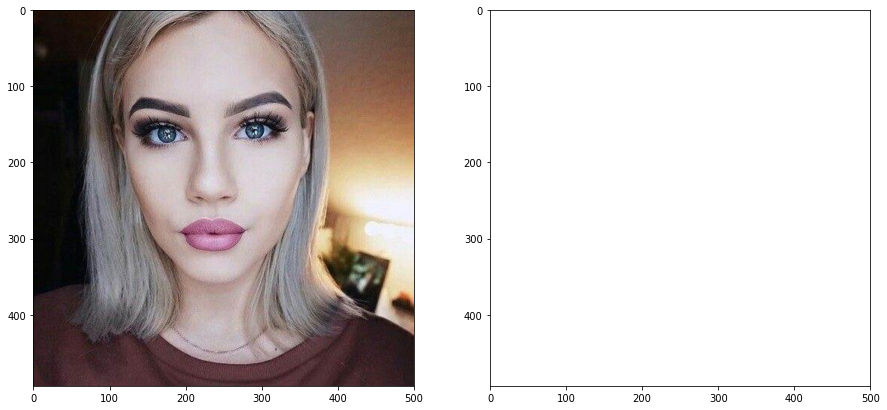

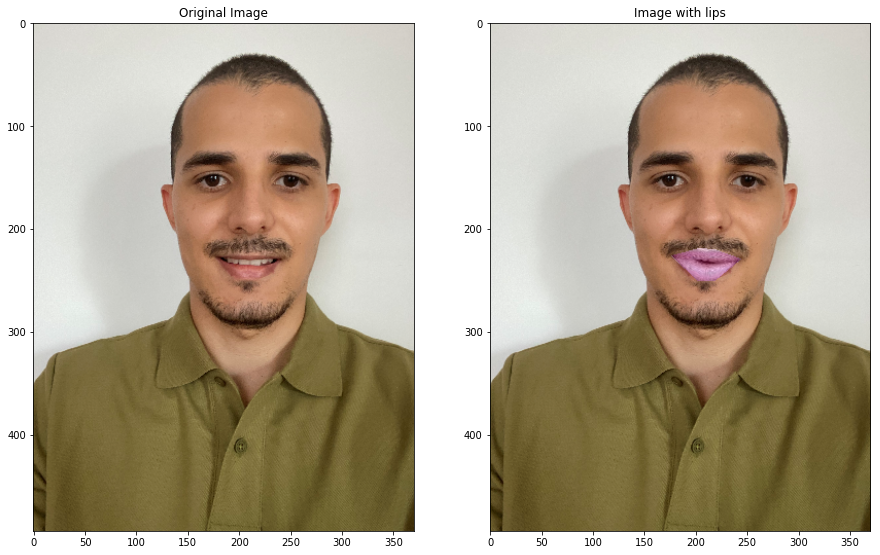

In [106]:
fn_Main_makeup_lips(modelPath,directory_input,directory_output)

## Call the function to apply left eyelash on image with lips

array([[[0.81960785, 0.8509804 , 0.84705883],
        [0.80784315, 0.8392157 , 0.8392157 ],
        [0.80784315, 0.8392157 , 0.8392157 ],
        ...,
        [0.7764706 , 0.80392158, 0.81960785],
        [0.78039217, 0.80784315, 0.82352942],
        [0.79607844, 0.82352942, 0.8392157 ]],

       [[0.80392158, 0.83529413, 0.83529413],
        [0.82352942, 0.85490197, 0.85490197],
        [0.80784315, 0.8392157 , 0.8392157 ],
        ...,
        [0.7764706 , 0.80392158, 0.81960785],
        [0.78431374, 0.81568629, 0.83137256],
        [0.7764706 , 0.80392158, 0.81960785]],

       [[0.80784315, 0.84313726, 0.84313726],
        [0.81960785, 0.8509804 , 0.8509804 ],
        [0.80784315, 0.84313726, 0.84313726],
        ...,
        [0.78039217, 0.81176472, 0.82745099],
        [0.78431374, 0.81568629, 0.83137256],
        [0.79215688, 0.81960785, 0.83529413]],

       ...,

       [[0.18431373, 0.36862746, 0.42745098],
        [0.21176471, 0.39607844, 0.4509804 ],
        [0.14901961, 0

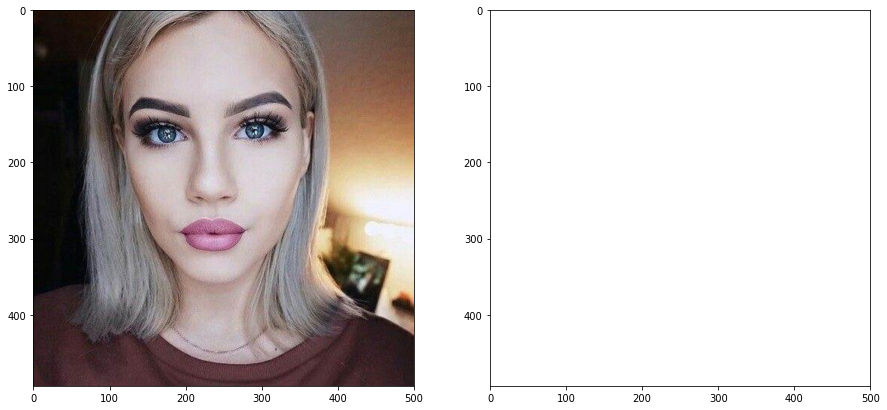

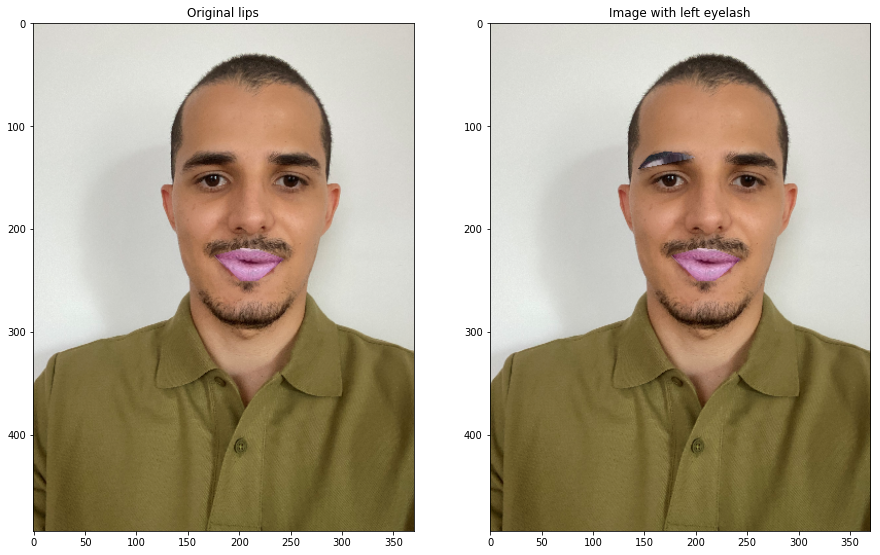

In [107]:
fn_Main2_makeup_eyelash_left(modelPath,directory_input,directory_output)

## Call the function to apply right eyelash on image with lip and lift eyelash

array([[[0.81960785, 0.8509804 , 0.84705883],
        [0.80784315, 0.8392157 , 0.8392157 ],
        [0.80784315, 0.8392157 , 0.8392157 ],
        ...,
        [0.7764706 , 0.80392158, 0.81960785],
        [0.78039217, 0.80784315, 0.82352942],
        [0.79607844, 0.82352942, 0.8392157 ]],

       [[0.80392158, 0.83529413, 0.83529413],
        [0.82352942, 0.85490197, 0.85490197],
        [0.80784315, 0.8392157 , 0.8392157 ],
        ...,
        [0.7764706 , 0.80392158, 0.81960785],
        [0.78431374, 0.81568629, 0.83137256],
        [0.7764706 , 0.80392158, 0.81960785]],

       [[0.80784315, 0.84313726, 0.84313726],
        [0.81960785, 0.8509804 , 0.8509804 ],
        [0.80784315, 0.84313726, 0.84313726],
        ...,
        [0.78039217, 0.81176472, 0.82745099],
        [0.78431374, 0.81568629, 0.83137256],
        [0.79215688, 0.81960785, 0.83529413]],

       ...,

       [[0.18431373, 0.36862746, 0.42745098],
        [0.21176471, 0.39607844, 0.4509804 ],
        [0.14901961, 0

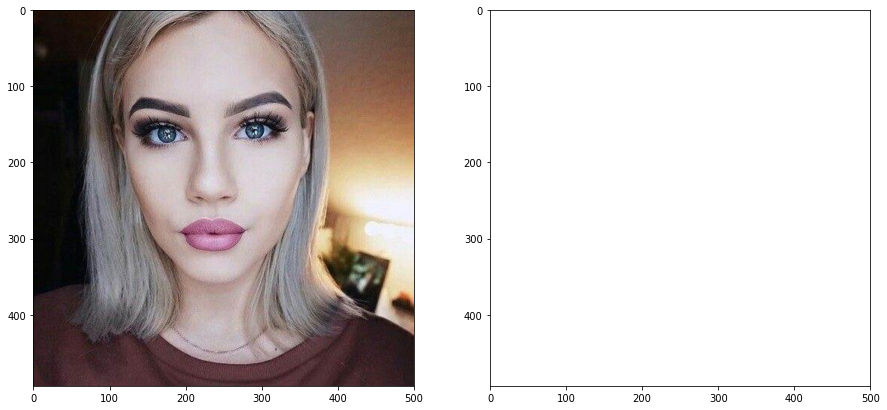

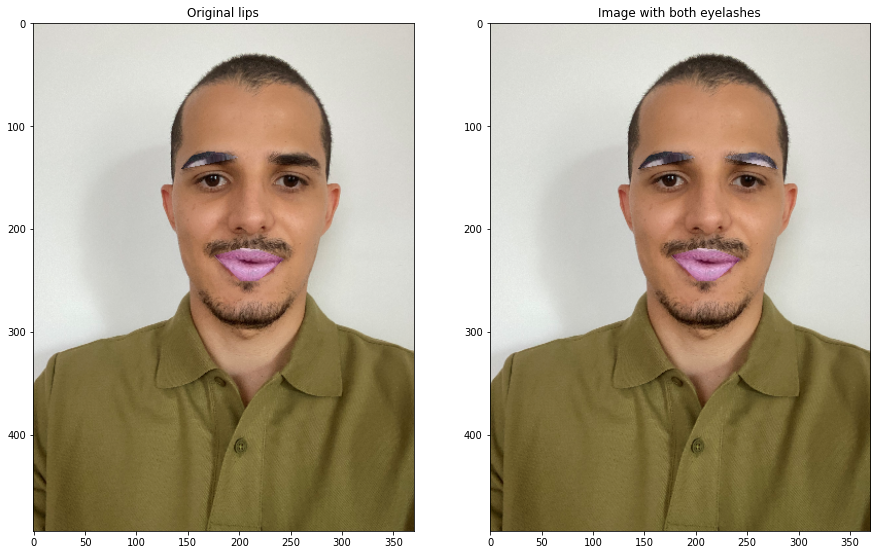

In [108]:
fn_Main2_makeup_eyelash_right(modelPath,directory_input,directory_output)